In [1]:
from Data_Loader import load_data
from Train import trainCox_nnet

import torch
import numpy as np
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [2]:
dtype = torch.FloatTensor
''' Net Settings'''
In_Nodes = 55553 ###number of genes
Hidden_Nodes = 100 ###number of hidden nodes
Out_Nodes = 30 ###number of hidden nodes in the last hidden layer
''' Initialize '''
Initial_Learning_Rate = [0.03, 0.01, 0.001, 0.00075]
L2_Lambda = [0.1, 0.01, 0.005, 0.001]
num_epochs = 10 ###for grid search
Num_EPOCHS = 50 ###for training
###sub-network setup
Dropout_Rate = [0.7]

In [3]:
from Data_extraction import output_df2, x_df2  

In [14]:
# print(len(ytime_train))

106


In [4]:
data = pd.concat([x_df2,output_df2],axis=1)

def split_indices(n, val_pct1, val_pct2):
	n1 = int(val_pct1*n)
	n2 = int(val_pct2*n)
	idxs = np.random.permutation(n)
	return idxs[:n1], idxs[n1:n2], idxs[n2:]

train_index, val_index, test_index = split_indices(len(data),0.6, 0.8)
data_train = data.iloc[train_index]
data_val = data.iloc[val_index]
data_test = data.iloc[test_index]

x_train, ytime_train, yevent_train, age_train = load_data(data_train, dtype)
x_valid, ytime_valid, yevent_valid, age_valid = load_data(data_val, dtype)
x_test, ytime_test, yevent_test, age_test = load_data(data_test,dtype)

c:\Users\anais\Documents\2-Imperial\0-Research-Project\4-NN\Cox-nnet model\src\Data_Loader.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['days_to_last_follow_up']=np.where(data['days_to_last_follow_up']=="'--", 1000, data['days_to_last_follow_up'])
c:\Users\anais\Documents\2-Imperial\0-Research-Project\4-NN\Cox-nnet model\src\Data_Loader.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['days_to_death']= np.where(data['days_to_death'] == "'--", data['days_to_last_follow_up'],data['days_t

In [33]:
batch_size=5

train_sampler = SubsetRandomSampler(train_index)
train_loader = DataLoader(data, batch_size, sampler=train_sampler)

val_sampler=SubsetRandomSampler(val_index)
val_loader = DataLoader(data, batch_size, sampler=val_sampler)

In [39]:
print(train_sampler)

In [5]:
opt_l2_loss = 0
opt_lr_loss = 0
opt_loss = torch.Tensor([float("Inf")])
###if gpu is being used
if torch.cuda.is_available():
	opt_loss = opt_loss.cuda()
###
opt_c_index_va = 0
opt_c_index_tr = 0

In [6]:
# for l2 in L2_Lambda:
# 	for lr in Initial_Learning_Rate:
# 		loss_train, loss_valid, c_index_tr, c_index_va = trainCox_nnet(x_train, age_train, ytime_train, yevent_train, \
# 																x_valid, age_valid, ytime_valid, yevent_valid, \
# 																In_Nodes, Hidden_Nodes, Out_Nodes, \
# 																lr, l2, num_epochs, Dropout_Rate)
# 		if loss_valid < opt_loss:
# 			opt_l2_loss = l2
# 			opt_lr_loss = lr
# 			opt_loss = loss_valid
# 			opt_c_index_tr = c_index_tr
# 			opt_c_index_va = c_index_va
# 		print ("L2: ", l2, "LR: ", lr, "Loss in Validation: ", loss_valid)

In [6]:

###train Cox-PASNet with optimal hyperparameters using train data, and then evaluate the trained model with test data
###Note that test data are only used to evaluate the trained Cox-nnet
opt_lr_loss = 0.00075
opt_l2_loss = 0.01
loss_train, loss_test, c_index_tr, c_index_te = trainCox_nnet(x_train, age_train, ytime_train, yevent_train, \
							x_test, age_test, ytime_test, yevent_test,  \
							In_Nodes, Hidden_Nodes, Out_Nodes, \
							opt_lr_loss, opt_l2_loss, Num_EPOCHS, Dropout_Rate)
print ("Optimal L2: ", opt_l2_loss, "Optimal LR: ", opt_lr_loss)
# print("C-index in Test: ", c_index_te)



Optimal L2:  0.01 Optimal LR:  0.00075


In [7]:
loss_train2 = [k.detach().numpy() for k in loss_train]
loss_test2 = [k.detach().numpy() for k in loss_test]
c_index_tr2 = [k.detach().numpy() for k in c_index_tr]
c_index_te2 = [k.detach().numpy() for k in c_index_te]
epoch = np.arange(0,Num_EPOCHS+2,2)

In [8]:
# print(yevent_train)
print(len(yevent_train))

106


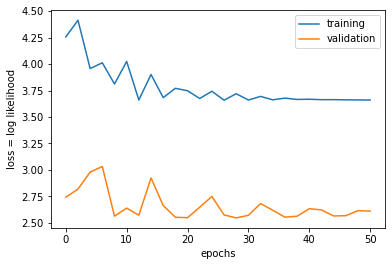

In [9]:
import matplotlib.pyplot as plt 
plt.plot(epoch, loss_train2, label = 'training')
plt.plot(epoch, loss_test2, label = 'validation')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()


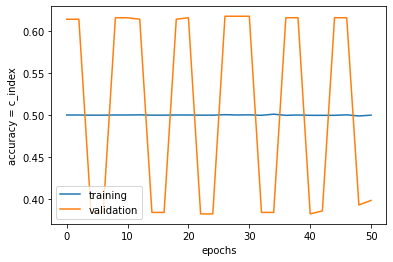

In [10]:
import matplotlib.pyplot as plt 
plt.plot(epoch, c_index_tr2, label = 'training')
plt.plot(epoch, c_index_te2, label = 'validation')
plt.ylabel('accuracy = c_index')
plt.xlabel('epochs')
plt.legend()


In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


In [17]:
get_default_device()

device(type='cpu')